In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Check CUDA Available

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.test.is_built_with_cuda()

True

## Load Dataset

In [5]:
batch_size = 32
img_height = 224
img_width = 224

data_dir = "backup\\plantvillage\\Preprocessed data"

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14531 files belonging to 10 classes.
Using 11625 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14531 files belonging to 10 classes.
Using 2906 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Bacterial_spot227', 'Early_blight227', 'Late_blight227', 'Leaf_Mold227', 'Septoria_leaf_spot227', 'Target_Spot227', 'Tomato_Yellow_Leaf_Curl_Virus227', 'Tomato_mosaic_virus227', 'Two-spotted_spider_mite227', 'healthy227']


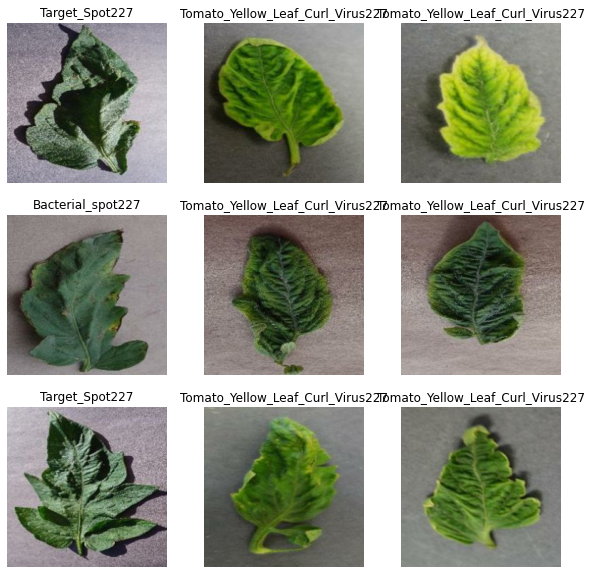

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [11]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

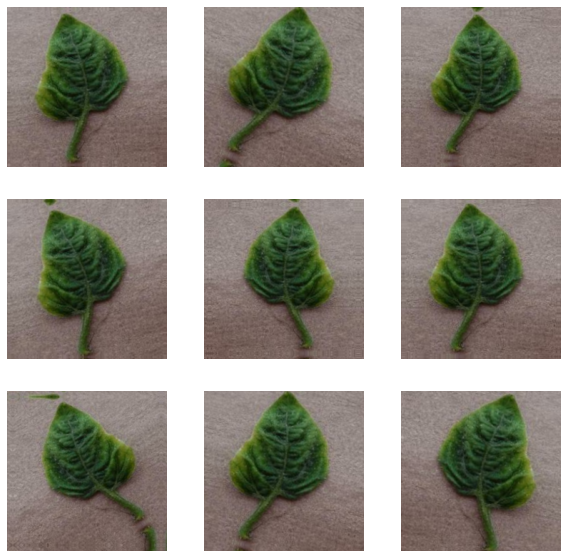

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
num_classes = 10

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)       

In [17]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="model.h5",
                                                 save_weights_only=True,
                                                 verbose=10)

In [18]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
364/364 [==============================] - 29s 33ms/step - loss: 1.4488 - accuracy: 0.4947 - val_loss: 0.6460 - val_accuracy: 0.7701
Epoch 2/20
364/364 [==============================] - 7s 18ms/step - loss: 0.5549 - accuracy: 0.8125 - val_loss: 0.5479 - val_accuracy: 0.8142
Epoch 3/20
364/364 [==============================] - 6s 18ms/step - loss: 0.4479 - accuracy: 0.8426 - val_loss: 0.3826 - val_accuracy: 0.8679
Epoch 4/20
364/364 [==============================] - 6s 18ms/step - loss: 0.3379 - accuracy: 0.8825 - val_loss: 0.6464 - val_accuracy: 0.8035
Epoch 5/20
364/364 [==============================] - 6s 18ms/step - loss: 0.3106 - accuracy: 0.8928 - val_loss: 0.4058 - val_accuracy: 0.8689
Epoch 6/20
364/364 [==============================] - 7s 18ms/step - loss: 0.2401 - accuracy: 0.9156 - val_loss: 0.4585 - val_accuracy: 0.8603
Epoch 7/20
364/364 [==============================] - 7s 18ms/step - loss: 0.2068 - accuracy: 0.9251 - val_loss: 0.3369 - val_accuracy: 0.889

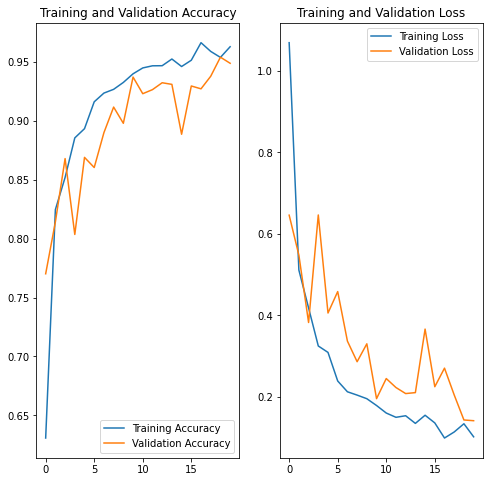

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
model.save("model.h5")

# Prediction

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [22]:
model = keras.models.load_model('model.h5')

In [23]:
class_names = ['Bacterial_spot227', 'Early_blight227', 'Late_blight227', 'Leaf_Mold227', 'Septoria_leaf_spot227', 'Target_Spot227', 'Tomato_Yellow_Leaf_Curl_Virus227', 'Tomato_mosaic_virus227', 'Two-spotted_spider_mite227', 'healthy227']

In [24]:
image_path = "backup\plantvillage\Preprocessed data\Bacterial_spot227\Bs2.jpg"
img_height = 224
img_width = 224

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Bacterial_spot227 with a 99.95 percent confidence.
